# Tool Windows Example

Tool windows are child windows of the IDE that allow to display additional information or provide always-visible user interface elements. The [IntelliJ Platform Plugin SDK](https://plugins.jetbrains.com/docs/intellij/tool-windows.html) provides more detailed description of capabilities.

Let's create a tool window that will display current time.

Firstly, let's enable IntelliJ Platform integration and load necessary libraries.

In [1]:
%use intellij-platform

IntelliJ Platform integration is loaded

Now we can run this cell and make sure that the integration was properly initialized. Before doing this, it is important to choose _Run in IDE Process_ mode.

## Creating a Tool Window

The simplest tool window will contain a single Swing component: a label with the current time.

![Tool Window with current time](tool_window/tool_window_right.png)

Only two classes are required:

1. A class that contains Swing components displayed as a content of the tool window.
2. A factory that creates a tool window and initializes it with the holder. This is an implementation of [`ToolWindowFactory`](https://github.com/JetBrains/intellij-community/blob/2abdc470260d83f16a498ffa0f1cc1ac1e9b38ae/platform/platform-api/src/com/intellij/openapi/wm/ToolWindowFactory.kt) interface from Platform SDK.

Additionally, we need a simple Kotlin script that will programmatically register this factory to the Platform.
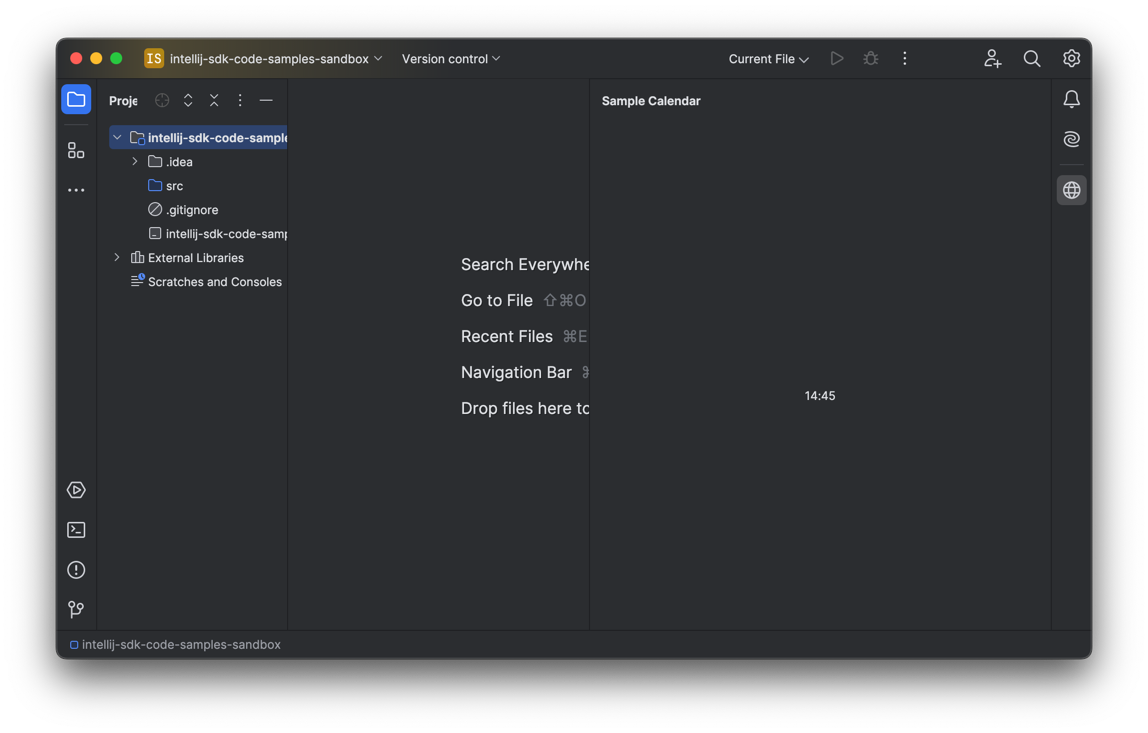

### Tool Window Content Class

Now it's the time to prepare some actual user interface content. `CurrentTimeToolWindowContent` is a simple class that contains a Swing panel with a label that will display current time.

In [2]:
import java.awt.BorderLayout
import java.time.ZonedDateTime
import java.time.format.DateTimeFormatter
import javax.swing.BorderFactory
import javax.swing.JLabel
import javax.swing.JPanel
import javax.swing.SwingConstants

class CurrentTimeToolWindowContent {
    val contentPanel = JPanel()

    private val currentTime = JLabel().apply {
        horizontalAlignment = SwingConstants.CENTER
    }

    init {
        with(contentPanel) {
            layout = BorderLayout(0, 20)
            border = BorderFactory.createEmptyBorder(40, 0, 0, 0)
            add(currentTime, BorderLayout.CENTER)
        }
        updateCurrentTime()
    }

    fun updateCurrentTime() {
        currentTime.text = ZonedDateTime.now().format(TIME_FORMATTER)
    }

    companion object {
        private val TIME_FORMATTER = DateTimeFormatter.ofPattern("HH:mm")
    }
}

### Tool Window Factory

#### Simple Tool Window Factory

A tool window factory will create a user interface component and register it in an instance of `ToolWindow`.
Since our user interface component is represented by the `CurrentTimeToolWindowContent`, we will implement the corresponding interface (`ToolWindowFactory`) and override the single required method.

In [3]:
import com.intellij.openapi.project.DumbAware
import com.intellij.openapi.project.Project
import com.intellij.openapi.wm.ToolWindow
import com.intellij.openapi.wm.ToolWindowFactory
import com.intellij.ui.content.ContentFactory

class CurrentTimeToolWindowFactory : ToolWindowFactory, DumbAware {
    override fun createToolWindowContent(project: Project, toolWindow: ToolWindow) {
        val toolWindowContent = CurrentTimeToolWindowContent()
        val content = ContentFactory.getInstance().createContent(
            toolWindowContent.contentPanel, "", false
        )
        toolWindow.contentManager.addContent(content)
    }
}

We will create an instance of `CurrentTimeToolWindowFactory` and let it setup the central `contentPanel`. Then, we need to adapt the Swing component into more generic `Content` that is managed by the tool window content manager.

#### Little Bit of Interactivity

To make this tool window more interactive, we will add a single _Refresh_ Button right to the tool window toolbar.

The tool window class `ToolWindow` allows to display arbitrary actions, rendered as buttons. The method `setTitleActions` is provided with list of `AnAction` instances.

Since we do not need access to indices, we can wrap an arbitrary lambda with `DumbAwareAction` and its `create` method. This lambda will invoke the corresponding refresh method on the tool window content class.

In [4]:
import com.intellij.icons.AllIcons
import com.intellij.openapi.project.DumbAware
import com.intellij.openapi.project.DumbAwareAction
import com.intellij.openapi.project.Project
import com.intellij.openapi.wm.ToolWindow
import com.intellij.openapi.wm.ToolWindowFactory
import com.intellij.ui.content.ContentFactory

class CurrentTimeToolWindowFactory : ToolWindowFactory, DumbAware {
    override fun createToolWindowContent(project: Project, toolWindow: ToolWindow) {
        val toolWindowContent = CurrentTimeToolWindowContent()
        val content = ContentFactory.getInstance().createContent(
            toolWindowContent.contentPanel, "", false
        )
        toolWindow.contentManager.addContent(content)

        toolWindow.setTitleActions(listOf(createRefreshAction(toolWindowContent)))
    }

    private fun createRefreshAction(toolWindowContent: CurrentTimeToolWindowContent) =
        DumbAwareAction.create("Refresh", AllIcons.Actions.Refresh) {
            toolWindowContent.updateCurrentTime()
        }
}

## Registering the Tool Window Factory

In Kotlin Notebook, there is no notion of the plugin descriptor that can declare the Tool Window Factory. Instead, we we need to register it programmatically.

We will use the `registerToolWindow` function that allows to configure various aspects of our tool window. Most importantly, we need to provide a tool window factory instance (`CurrentTimeToolWindowFactory`). Additionally, we need to specify the ID of the tool window, which serves a role of a tooltip. Finally, we provide a generic _information_ icon that will be shown in the tool window stripe.

To register that tool window factory, we need a `ToolWindowManager` retrieved by its static factory method. A required instance of the project can be retrieved with helper function `currentProject` and its error handling function `error`.

All of this needs to happen in the correct thread. Event Dispatch Thread (EDT), to be more precise. According to the [documentation](https://plugins.jetbrains.com/docs/intellij/tool-windows.html#programmatic-setup), we will use dedicated `invokeLater` method provided by the Tool Window Manager. Incorrect usage might invoke hard-to-debug issues, such as tool window not being shown in the tool window bar.

Finally, we need to handle the unloading process, but that will be described in a while. Let's run this notebook!

In [5]:
import com.intellij.icons.AllIcons
import com.intellij.openapi.util.Disposer
import com.intellij.openapi.wm.ToolWindowManager
import com.intellij.openapi.wm.ToolWindowAnchor
import org.jetbrains.kotlinx.jupyter.intellij.notebookDisposable

val project = currentProject() ?: error("Project not found")
val toolWindowManager = ToolWindowManager.getInstance(project)
toolWindowManager.invokeLater {
    val toolWindowId = "Current Time"
    val toolWindow = toolWindowManager.getToolWindow(toolWindowId)
        ?: toolWindowManager.registerToolWindow(toolWindowId) {
            icon = AllIcons.General.Information
            contentFactory = CurrentTimeToolWindowFactory()
            anchor = ToolWindowAnchor.RIGHT
        }

    Disposer.register(notebookDisposable) {
        toolWindow.remove()
    }
}

We should be able to see the tool window icon in the right left tool window bar.

## Hot-reloading

Kotlin Notebooks allow to quickly reload the notebook, along with changes in the IDE. However, we need to properly register the unloading of the tool window.

```kotlin
Disposer.register(notebookDisposable) {
    toolWindow.remove()
}
```
The `notebookDisposable` is an implicit variable provided by Kotlin Notebook IntelliJ Platform integration that can be registered to a `Disposer`. We will register a callback that will unload and remove the tool window when the Kotlin Notebook Kernel is restarted.

Let's _Restart Kernel_ by the corresponding button. The tool window will disappear, and its icon in the tool window bar will be removed.

# Summary

- Use `ToolWindowManager` to register a tool window content by using `registerToolWindow` helper function
- Use `ToolWindowFactory` subclass to provide a Swing component with tool window content.
- Configure tool window content in a separate class that will provide a hierarchy of Swing components when using complex tool windows.
- Use `setTitleActions` on a `ToolWindow` instance to contribute buttons to the tool window toolbar.
- Enable hot reloaading by properly registering disposable objects that properly unload the corresponding tool window.
- Make sure that thread-safety is guaranteed by using `invokeLater` on the Tool Window Manager.